In [135]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns 


from pandas.plotting import scatter_matrix
from sklearn.metrics import *
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier,plot_importance
%matplotlib inline

# Set font size for plotting
sns.set(font_scale=1.5)

In [12]:
df = pd.read_csv('churn.csv', parse_dates=['last_trip_date', 'signup_date'])

In [13]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [16]:
df.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [41]:
#Create target variable based on the given condition 
#Condition: A rider is considered 'retained' if they are active (i.e. took a trip) in the preceding 30 days from the day data was pulled (07/01/2014)

last_active_date = dt.datetime(2014,7,1)
cutoff_date=last_active_date-dt.timedelta(days=30)
df['active'] = (df['last_trip_date']>cutoff_date).astype(int)

In [42]:
#1 represents active/retained and 0 represents churn
df.active.value_counts()

0    31690
1    18310
Name: active, dtype: int64

In [63]:
#Find missing values for each feature
df.isnull().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                        0
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
active                       0
dtype: int64

In [23]:
#Impute missing values in phone feature with 'no phone' 
df.phone = df.phone.fillna('no_phone')

In [25]:
df.phone.value_counts()

iPhone      34582
Android     15022
no_phone      396
Name: phone, dtype: int64

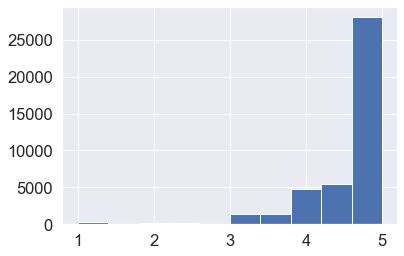

In [62]:
df.avg_rating_of_driver.hist()

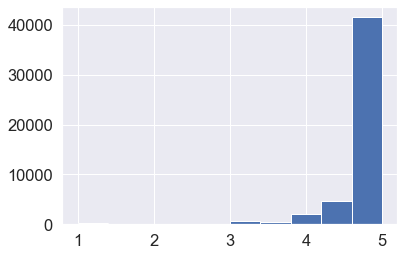

In [55]:
df.avg_rating_by_driver.hist()

In [79]:
#Impute missing values in avg_rating features using KNN approach. Multiple Imputation By Chained Equation approach can also be used
imputer=KNNImputer(n_neighbors=5,weights="distance",metric="nan_euclidean")
df['avg_rating_by_driver']=imputer.fit_transform(df[['avg_rating_by_driver']])
df['avg_rating_of_driver']=imputer.fit_transform(df[['avg_rating_of_driver']])


In [80]:
#check for missing values now
df.isnull().sum()

avg_dist                  0
avg_rating_by_driver      0
avg_rating_of_driver      0
avg_surge                 0
city                      0
last_trip_date            0
phone                     0
signup_date               0
surge_pct                 0
trips_in_first_30_days    0
luxury_car_user           0
weekday_pct               0
active                    0
dtype: int64

In [83]:
#one hot encode city and phone attributes
df=pd.get_dummies(df, prefix_sep='_', drop_first=True,columns=['city','phone'])

In [84]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,active,city_King's Landing,city_Winterfell,phone_iPhone,phone_no_phone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,True,46.2,1,1,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,False,50.0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,False,100.0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,True,80.0,1,1,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,False,82.4,0,0,1,0,0


In [87]:
#label encode luxury_car_user attribute
df['luxury_car_user'] = LabelEncoder().fit_transform(
    df['luxury_car_user'])

In [88]:
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,last_trip_date,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct,active,city_King's Landing,city_Winterfell,phone_iPhone,phone_no_phone
0,3.67,5.0,4.7,1.10,2014-06-17,2014-01-25,15.4,4,1,46.2,1,1,0,1,0
1,8.26,5.0,5.0,1.00,2014-05-05,2014-01-29,0.0,0,0,50.0,0,0,0,0,0
2,0.77,5.0,4.3,1.00,2014-01-07,2014-01-06,0.0,3,0,100.0,0,0,0,1,0
3,2.36,4.9,4.6,1.14,2014-06-29,2014-01-10,20.0,9,1,80.0,1,1,0,1,0
4,3.13,4.9,4.4,1.19,2014-03-15,2014-01-27,11.8,14,0,82.4,0,0,1,0,0


In [89]:
# Remove redundant and leaky predictors to prevent data leakage
df.drop(columns=['last_trip_date',
                   'signup_date'], inplace=True)

In [128]:
# Setting up training and test sets
X = df.drop('active', axis=1)
y = df['active']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [129]:
#Define models to predict the target variable - active
log_clf = LogisticRegression(solver="liblinear",max_iter=100, random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
gb_clf= GradientBoostingClassifier(n_estimators=50, learning_rate=1)
xgb_clf=XGBClassifier(max_depth=8, 
                                learning_rate=.1, 
                                n_estimators=100, 
                                gamma=0, 
                                min_child_weight=1, 
                                subsample=0.8, 
                                objective='binary:logistic') 

In [130]:
#Fit scaler to training set and use it to transform training and test sets
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
X_test_scaled=scaler.transform(X_test)

Accuracy: LogisticRegression 0.7211
AUC score: LogisticRegression 0.675377239841399
F1 Score: LogisticRegression 0.5699306090979183
Accuracy: RandomForestClassifier 0.7582
AUC score: RandomForestClassifier 0.736216641817529
F1 Score: RandomForestClassifier 0.6651896981445583
Accuracy: GradientBoostingClassifier 0.7896
AUC score: GradientBoostingClassifier 0.7638364281648331
F1 Score: GradientBoostingClassifier 0.6996859834427633
Accuracy: XGBClassifier 0.7965
AUC score: XGBClassifier 0.7718520168055518
F1 Score: XGBClassifier 0.7104027323182012


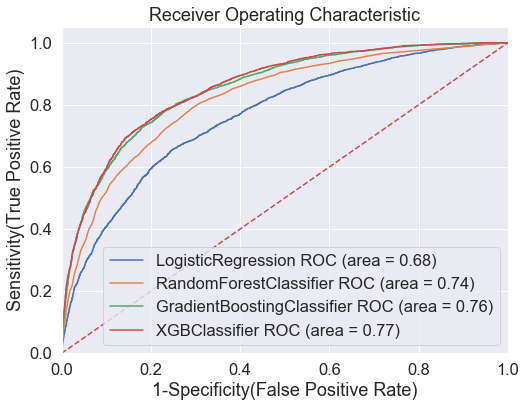

In [131]:
#Fit models, compute metrics and plot ROC curves for comparison
plt.figure(figsize=(8, 6))
for clf in (log_clf, rnd_clf, gb_clf,xgb_clf):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    print('Accuracy: '+clf.__class__.__name__, accuracy_score(y_test, y_pred))
    print('AUC score: '+clf.__class__.__name__, roc_auc_score(y_test, y_pred))
    print('F1 Score: '+clf.__class__.__name__, f1_score(y_test, y_pred))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test_scaled)[:,1])
    auc = roc_auc_score(y_test,clf.predict(X_test_scaled))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (clf.__class__.__name__, auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display    

XGBoost algorithm outperforms other classifiers based on the three metrics: AUC score, test accuracy and F1 score. We can fine tune our classifiers using GridSearchCV or RandomizedSearchCV that gives us best combination of parameters. However, it is expected that ensemble models like XGBoost/Gradient Boost outperform other classifiers

In [190]:
#Plot feature importance
xgb_clf.fit(X_train_scaled, y_train)
important_features=pd.DataFrame(zip(X.columns,xgb_clf.get_booster().get_fscore().values()),columns=['Features','F score']).sort_values(by=['F score'], ascending=False)

In [191]:
important_features

,Features,F score
5,trips_in_first_30_days,4715
6,luxury_car_user,2077
3,avg_surge,1722
9,city_Winterfell,1586
0,avg_dist,1116
7,weekday_pct,1093
10,phone_iPhone,1020
2,avg_rating_of_driver,462
11,phone_no_phone,384
4,surge_pct,353


Text(0.5, 0, 'Feature Importance Score')

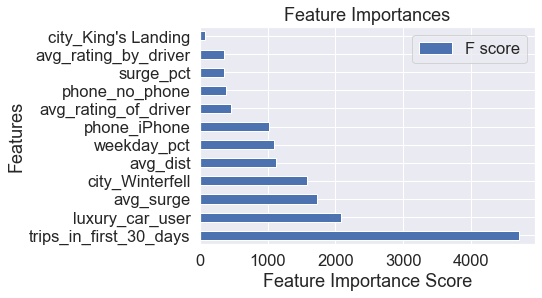

In [200]:
important_features.set_index('Features').plot(kind='barh',title='Feature Importances')
plt.xlabel('Feature Importance Score')